In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from geoband.API import *
import folium
import json
import geopandas as gpd
import warnings 
warnings.filterwarnings('ignore')

from shapely.geometry import Point, shape, mapping
from shapely.ops import unary_union

In [3]:
data2 = gpd.read_file('2.오산시_어린이교통사고_격자.geojson')
data17 = gpd.read_file('17.오산시_횡단보도.geojson')
data19 = gpd.read_file('19.오산시_신호등.geojson')
data21 = gpd.read_file('21.오산시_인도.geojson')
data22 = pd.read_csv('22.오산시_버스정류장.csv')
data18 = pd.read_csv('18.오산시_과속방지턱표준데이터.csv')
data9 = pd.read_csv('9.오산시_어린이보호구역.csv')
data21 = gpd.read_file('21.오산시_인도.geojson')


In [5]:
import pyproj
from fiona.crs import from_epsg

geom_data9 = gpd.points_from_xy(data9['보호구역_경도'], data9['보호구역_위도'])
coulumns = ['시설종류', '시설명', '보호구역도로폭']
gdf_data9 = gpd.GeoDataFrame(data9[coulumns], geometry=geom_data9, crs=from_epsg(4326))

gdf9 = gdf_data9.to_crs(epsg='4326')
gdf9_buf = gpd.GeoDataFrame()
gdf9_buf['geometry'] = gdf9.buffer(0.00013)
gdf9_buf = gpd.GeoDataFrame(data9[coulumns], geometry=gdf9_buf.geometry,crs=from_epsg(4326) )

In [6]:
gdf2 = data2.to_crs(epsg='4326')


result = []
for i in range(len(gdf2)):
    result.append(data19.within(gdf2.geometry[i]))

res_df = pd.DataFrame(result)
cnt1 = res_df.transpose().sum()
gdf2['신호등개수'] = cnt1

In [7]:
geom_data22 = gpd.points_from_xy(data22['정류장 위치_경도'], data22['정류장 위치_위도'])

result = []
for i in range(len(gdf2)):
    result.append(geom_data22.within(gdf2.geometry[i]))

res_df = pd.DataFrame(result)
cnt2 = res_df.transpose().sum()

gdf2['버스정류장개수'] = cnt2

In [9]:
geom_data18 = gpd.points_from_xy(data18['설치위치_경도'], data18['설치위치_위도'])

result = []
for i in range(len(gdf2)):
    result.append(geom_data18.within(gdf2.geometry[i]))

res_df = pd.DataFrame(result)
cnt3 = res_df.transpose().sum()

gdf2['과속방지턱개수'] = cnt3

In [12]:
gdf21_buf = gpd.GeoDataFrame()
columns = ['QUAL', 'BYYN', 'KIND']
gdf21_buf['geometry'] = data21.buffer(0.00013)
gdf21_buf = gpd.GeoDataFrame(data21[columns], geometry=gdf21_buf.geometry,crs=from_epsg(4326) )

gdf17 = data17.to_crs(epsg='4326')

gdf_21 = gpd.overlay(gdf2, gdf21_buf, how='intersection')
gdf_17 = gpd.overlay(gdf2, gdf17, how='intersection')

In [13]:
gdf2['횡단보도개수']=0
x = gdf2.merge(gdf_17.dissolve(by='gid', aggfunc='sum'), on='gid')
y = x.gid
for i in range(len(gdf2)):
    for j in range(len(y)):
        if gdf2.gid[i] == y[j]:
            gdf2['횡단보도개수'][i] = x.accident_cnt_y[j]//gdf2.accident_cnt[i]

In [14]:
gdf2['인도개수']=0
x = gdf2.merge(gdf_21.dissolve(by='gid', aggfunc='sum'), on='gid')
y = x.gid
for i in range(len(gdf2)):
    for j in range(len(y)):
        if gdf2.gid[i] == y[j]:
            gdf2['인도개수'][i] = x.accident_cnt_y[j]//gdf2.accident_cnt[i]

In [15]:
gdf2_1 = gdf2[gdf2['인도개수'] == 0]
gdf2_2 = gdf2_1[gdf2_1['횡단보도개수'] == 0]
gdf2

,gid,accident_cnt,geometry,신호등개수,버스정류장개수,과속방지턱개수,횡단보도개수,인도개수
0,다사551085,0,"MULTIPOLYGON (((126.99422 37.17418, 126.99421 ...",0,0,0,0,0
1,다사551086,0,"MULTIPOLYGON (((126.99421 37.17508, 126.99420 ...",0,0,0,0,0
2,다사551087,0,"MULTIPOLYGON (((126.99420 37.17599, 126.99420 ...",0,0,0,0,0
3,다사551088,0,"MULTIPOLYGON (((126.99420 37.17689, 126.99419 ...",0,0,0,0,0
4,다사552085,0,"MULTIPOLYGON (((126.99534 37.17419, 126.99534 ...",0,0,0,0,0
...,...,...,...,...,...,...,...,...
4505,다사646052,0,"MULTIPOLYGON (((127.10138 37.14484, 127.10138 ...",0,0,0,0,0
4506,다사646053,0,"MULTIPOLYGON (((127.10138 37.14575, 127.10137 ...",0,0,0,0,0
4507,다사647050,0,"MULTIPOLYGON (((127.10252 37.14305, 127.10251 ...",0,0,0,0,0
4508,다사647051,0,"MULTIPOLYGON (((127.10251 37.14395, 127.10251 ...",0,0,0,0,0


In [16]:
cor_region = pd.DataFrame({"accident_count" : gdf2['accident_cnt'],
                         "x1" : gdf2['신호등개수'], 
                         "x2" : gdf2['버스정류장개수'],
                         "x3" : gdf2['과속방지턱개수'],
                         "x4" : gdf2['횡단보도개수'],
                         "x5" : gdf2['인도개수']
                          })

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

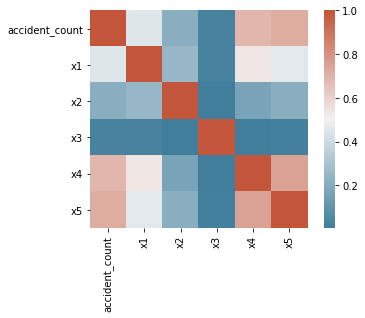

In [18]:
sns.heatmap(cor_region.corr(), cmap=sns.diverging_palette(230, 20, as_cmap=True),
           square=True)

In [19]:
cor_region.corr()

,accident_count,x1,x2,x3,x4,x5
accident_count,1.000000,0.451419,0.212607,0.027195,0.685628,0.722078
x1,0.451419,1.000000,0.252342,0.026853,0.538613,0.462298
x2,0.212607,0.252342,1.000000,0.009147,0.167066,0.213026
x3,0.027195,0.026853,0.009147,1.000000,0.005883,0.015604
x4,0.685628,0.538613,0.167066,0.005883,1.000000,0.752181
x5,0.722078,0.462298,0.213026,0.015604,0.752181,1.000000


## 사고가 있었던 어린이 보호구역

In [44]:
accident1 = data2.loc[data2['accident_cnt']>=1]
gdf1 = accident1.to_crs(epsg='4326')

In [45]:
gdf = gpd.overlay(gdf1, gdf9_buf, how='intersection')

In [46]:
accident2 = gpd.GeoDataFrame(gdf['gid'])

In [47]:
accident_region = accident1.merge(accident2, on='gid')

In [48]:
accident_region 

,gid,accident_cnt,geometry
0,다사591095,1,"MULTIPOLYGON (((127.03922 37.18338, 127.03921 ..."
1,다사595096,1,"MULTIPOLYGON (((127.04372 37.18430, 127.04371 ..."
2,다사601053,1,"MULTIPOLYGON (((127.05071 37.14556, 127.05070 ..."
3,다사604086,1,"MULTIPOLYGON (((127.05391 37.17532, 127.05391 ..."
4,다사605080,1,"MULTIPOLYGON (((127.05507 37.16992, 127.05506 ..."
5,다사606070,1,"MULTIPOLYGON (((127.05625 37.16091, 127.05624 ..."
6,다사606070,1,"MULTIPOLYGON (((127.05625 37.16091, 127.05624 ..."
7,다사607067,1,"MULTIPOLYGON (((127.05739 37.15821, 127.05739 ..."
8,다사607068,3,"MULTIPOLYGON (((127.05739 37.15911, 127.05738 ..."
9,다사610068,1,"MULTIPOLYGON (((127.06076 37.15912, 127.06076 ..."


In [68]:
groupped = accident_region.dissolve(by = 'gid',  aggfunc='first')

In [117]:
groupped.index[1]

'다사595096'

In [119]:
n = len(groupped)
n

20

In [140]:
gdf2['스쿨존개수']=0
for i in range(n):
    cnt = sum(accident_region['gid']==groupped.index[i])
    gdf2['스쿨존개수'][gdf2['gid']==groupped.index[i]] = cnt

### 완성된 전체 data

In [145]:
gdf2

,gid,accident_cnt,geometry,신호등개수,버스정류장개수,과속방지턱개수,횡단보도개수,인도개수,스쿨존개수
0,다사551085,0,"MULTIPOLYGON (((126.99422 37.17418, 126.99421 ...",0,0,0,0,0,0
1,다사551086,0,"MULTIPOLYGON (((126.99421 37.17508, 126.99420 ...",0,0,0,0,0,0
2,다사551087,0,"MULTIPOLYGON (((126.99420 37.17599, 126.99420 ...",0,0,0,0,0,0
3,다사551088,0,"MULTIPOLYGON (((126.99420 37.17689, 126.99419 ...",0,0,0,0,0,0
4,다사552085,0,"MULTIPOLYGON (((126.99534 37.17419, 126.99534 ...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
4505,다사646052,0,"MULTIPOLYGON (((127.10138 37.14484, 127.10138 ...",0,0,0,0,0,0
4506,다사646053,0,"MULTIPOLYGON (((127.10138 37.14575, 127.10137 ...",0,0,0,0,0,0
4507,다사647050,0,"MULTIPOLYGON (((127.10252 37.14305, 127.10251 ...",0,0,0,0,0,0
4508,다사647051,0,"MULTIPOLYGON (((127.10251 37.14395, 127.10251 ...",0,0,0,0,0,0


In [146]:
gdf2_withschool = gdf2[gdf2['스쿨존개수']!=0]

In [160]:
gdf2_withschool

,gid,accident_cnt,geometry,신호등개수,버스정류장개수,과속방지턱개수,횡단보도개수,인도개수,스쿨존개수
1503,다사591095,1,"MULTIPOLYGON (((127.03922 37.18338, 127.03921 ...",0,0,0,0,2,1
1821,다사595096,1,"MULTIPOLYGON (((127.04372 37.18430, 127.04371 ...",0,0,0,6,7,1
2234,다사601053,1,"MULTIPOLYGON (((127.05071 37.14556, 127.05070 ...",0,0,0,2,0,1
2489,다사604086,1,"MULTIPOLYGON (((127.05391 37.17532, 127.05391 ...",6,0,0,4,9,1
2555,다사605080,1,"MULTIPOLYGON (((127.05507 37.16992, 127.05506 ...",0,0,0,0,4,1
2618,다사606070,1,"MULTIPOLYGON (((127.05625 37.16091, 127.05624 ...",0,0,3,0,1,2
2688,다사607067,1,"MULTIPOLYGON (((127.05739 37.15821, 127.05739 ...",0,0,0,0,1,1
2689,다사607068,3,"MULTIPOLYGON (((127.05739 37.15911, 127.05738 ...",0,1,0,4,2,1
2913,다사610068,1,"MULTIPOLYGON (((127.06076 37.15912, 127.06076 ...",0,0,0,0,0,1
2918,다사610073,1,"MULTIPOLYGON (((127.06074 37.16363, 127.06073 ...",0,0,0,0,5,2


In [157]:
gdf2.to_csv("gdf2.csv",  encoding='utf-8', sep='\t') 

In [151]:
cor_region1 = pd.DataFrame({"accident_count" : gdf2_withschool['accident_cnt'],
                         "신호등" : gdf2_withschool['신호등개수'], 
                         "버정" : gdf2_withschool['버스정류장개수'],
                         "방지턱" : gdf2_withschool['과속방지턱개수'],
                         "횡단보도" : gdf2_withschool['횡단보도개수'],
                         "인도" : gdf2_withschool['인도개수'],
                         "스쿨존" : gdf2_withschool['스쿨존개수']})

<AxesSubplot:>

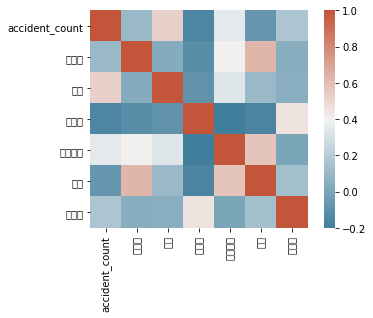

In [152]:
sns.heatmap(cor_region1.corr(), cmap=sns.diverging_palette(230, 20, as_cmap=True),
           square=True)

In [153]:
cor_region1.corr()

,accident_count,신호등,버정,방지턱,횡단보도,인도,스쿨존
accident_count,1.000000,0.100237,0.528886,-0.154672,3.532809e-01,-0.072889,1.685500e-01
신호등,0.100237,1.000000,0.034989,-0.115969,4.068418e-01,0.632230,4.460258e-02
버정,0.528886,0.034989,1.000000,-0.089984,3.425497e-01,0.106013,4.902903e-02
방지턱,-0.154672,-0.115969,-0.089984,1.000000,-2.003565e-01,-0.165351,4.588315e-01
횡단보도,0.353281,0.406842,0.342550,-0.200357,1.000000e+00,0.577001,-4.039980e-17
인도,-0.072889,0.632230,0.106013,-0.165351,5.770007e-01,1.000000,1.351406e-01
스쿨존,0.168550,0.044603,0.049029,0.458831,-4.039980e-17,0.135141,1.000000e+00


In [ ]:
import statsmodels.api as sm
model2 = sm.OLS(cor_region['accident_count'], cor_region.drop('accident_count', axis=1))
result = model2.fit()
result.summary()